# Compare Bowite2 global, Bowtie2 local, and Hisat2 mappers

In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn.objects as so
import pysam

## get number of reads per file

In [11]:
def count_reads(bam_file):
    bam = pysam.AlignmentFile(bam_file, "rb")
    total_reads = int(bam.count())
    paired_reads = int(total_reads / 2)
    bam.close()
    
    tumor_model, sample_id, tumor_tmp = bam_file.name.split("-")
    tissue_type, lib_tmp = tumor_tmp.split("_")
    library = lib_tmp.split(".")[0]
    df = pd.DataFrame({"tumor_model": [tumor_model],
                       "sample_id": [sample_id],
                        "tissue_type": [tissue_type],
                        "library": [library],
                        "total_reads": [total_reads],
                        "paired_reads": [paired_reads]})
    return df

def mapper_count_reads(bam_dir, in_file, mapper_name):
    files_df = pd.read_csv(in_file, sep="\t", header=None)
    reads_list = []
    for row in files_df.iterrows():
        mysample = row[1][0]
        
        irl_bam = bam_dir / (mysample + "_IRL.sam")
        reads_list.append(count_reads(irl_bam))

        irr_bam = bam_dir / (mysample + "_IRR.sam")
        reads_list.append(count_reads(irr_bam))
        
    reads_df = pd.concat(reads_list, axis=0).reset_index(drop=True)
    reads_df["mapper"] = mapper_name
    return reads_df

In [12]:
bowtie_local = Path("../toy-data/output/bowtie2-local/2020_SB-bam/")
bowtie_global = Path("../toy-data/output/bowtie2-global/2020_SB-bam/")
hisat= Path("../toy-data/output/hisat2/2020_SB-bam/")

input_file = Path("../toy-data/input.tsv")

compare_mappers_dir = Path("../toy-data/output/compare_mappers_results")
compare_mappers_dir.mkdir(parents=True, exist_ok=True)

In [13]:
bowtie_local_df = mapper_count_reads(bowtie_local, input_file, "bowtie2-local")
bowtie_local_df.to_csv(compare_mappers_dir / "bowtie2_local-read_counts.csv")

In [14]:
bowtie_global_df = mapper_count_reads(bowtie_global, input_file, "bowtie2-global")
bowtie_global_df.to_csv(compare_mappers_dir / "bowtie2_global-read_counts.csv")

In [15]:
hisat_df = mapper_count_reads(hisat, input_file, "hisat2")
hisat_df.to_csv(compare_mappers_dir / "hisat2-read_counts.csv")

## visualize read differences between mappers

In [16]:
data = pd.concat([bowtie_local_df, bowtie_global_df, hisat_df], ignore_index=True)
display(data)

,tumor_model,sample_id,tissue_type,library,total_reads,paired_reads,mapper
0,B16,1_1,RT,IRL,4632,2316,bowtie2-local
1,B16,1_1,RT,IRR,41117,20558,bowtie2-local
2,B16,1_1,S,IRL,2175,1087,bowtie2-local
3,B16,1_1,S,IRR,75396,37698,bowtie2-local
4,B16,1_1,RT,IRL,4632,2316,bowtie2-global
5,B16,1_1,RT,IRR,41117,20558,bowtie2-global
6,B16,1_1,S,IRL,2175,1087,bowtie2-global
7,B16,1_1,S,IRR,75396,37698,bowtie2-global
8,B16,1_1,RT,IRL,4646,2323,hisat2
9,B16,1_1,RT,IRR,41364,20682,hisat2


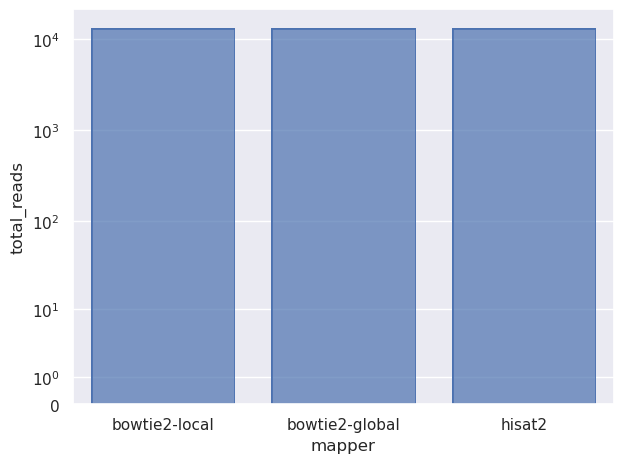

In [17]:
g = (
    so.Plot(data, x="mapper", y="total_reads")
    .add(so.Bar(), so.Agg("mean"))
    .scale(y="symlog")
)
g.show()

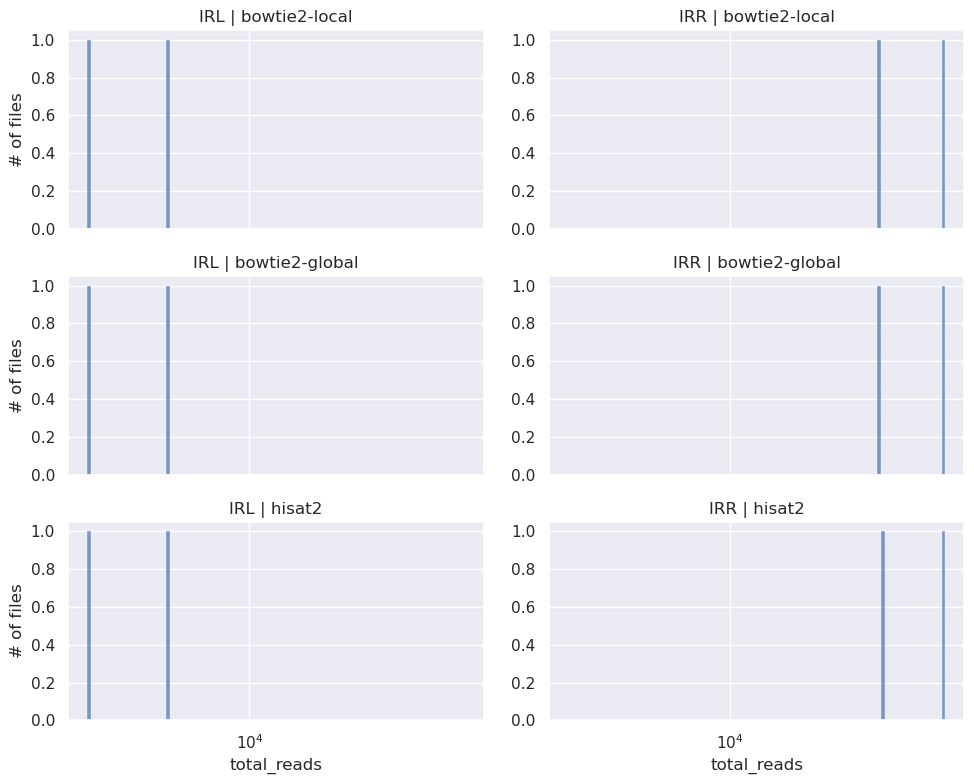

In [19]:
g = (
    so.Plot(data, x="total_reads")
    .add(so.Bars(), so.Hist(bins=100))
    .facet(col="library", row="mapper")
    .scale(x="symlog")
    .share(y=False)
    .layout(size=(10,8))
    .label(y="# of files")
)
g.show()


In [20]:
g = (
    so.Plot(data[data["mapper"] == "bowtie-local"], x="total_reads")
    .add(so.Bars(), so.Hist(bins=100))
    .facet(col="library", row="tumor_model")
    .scale(x="symlog")
    .share(y=False)
    .layout(size=(10,8))
)
g.show()

/project/cs-myers/MathewF/software/miniconda3/envs/netcis/lib/python3.10/site-packages/seaborn/_core/rules.py:164: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if variable_type(pd.Series(order)) == "numeric":


ValueError: Number of rows must be a positive integer, not 0

<Figure size 1000x800 with 0 Axes>

IRL R1 5': AAATTTGTGGAGTAGTTGAAAAACGA
IRR R1 5': GGATTAAATGTCAGGAATTGTGAAAA
adapter R1 5': TACCCATACGACGTCCCAGA

IRL R2 5': TTTAAACACCTCATCAACTTTTTGCT
IRR R2 5': CCTAATTTACAGTCCTTAACACTTTT
adapter R2 5': ATGGGTATGCTGCAGGGTCT

IRL
AdapterRemoval --identify-adapters --file1 1-1_RT_20170405000_20170405000_S384_L008_R1_001.fastq.gz --file2 1-1_RT_20170405000_20170405000_S384_L008_R2_001.fastq.gz --adapter1 AAATTTGTGGAGTAGTTGAAAAACGA --adapter2 TCTGGGACGTCGTATGGGTA

IRR
AdapterRemoval --identify-adapters --file1 1-1_RT_20170405001_20170405000_S465_L008_R1_001.fastq.gz --file2 1-1_RT_20170405001_20170405000_S465_L008_R2_001.fastq.gz --adapter1 GGATTAAATGTCAGGAATTGTGAAAA --adapter2 TACCCATACGACGTCCCAGA